# RSA experiment overview

This document consists of an overview of the experiments that will be done to shed more light on the effect of different initializations on the structure of emerging languages. In order to give a complete image of the effect on the structure, the research will consists of three parts. These three parts will be further clarified in this document, along with some results to back them up. 

The first part will consist of a hyperparameter search. We take the same setup and initialize it 10 different times using different seeds. 

The second part will utilize a mapping network. This mapping network will act as a translation machine. We will try to find whether differently intialized agents will keep the same structure in their language by 

The third part will consist of an experiment showing to what extent differently initialized agents are able to generalize. 

More information as to how and why we conduct these experiments will be added to the subsections.

## -----------------------------------------------------------------------------------------------------------------------------

## Plot code

In [5]:
import glob
import scipy.stats
import numpy as np
import pickle
import os

from itertools import combinations
from scipy import spatial
from metrics import rsa
from data import one_hot
from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

baseline_path = 'runs/lstm_max_len_5_vocab_3_attr_5'

In [50]:
def get_run_name(run:str)->str:
    if run == 'lstm_max_len_5_vocab_3_attr_5':
        return 'baseline'
    else:
        return run
    
def plot_metric(paths, metric="loss", run='baseline', ylabel=None, show_error=True, 
                savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27)):
    
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
    
    generations = []
    values = []
    run_names = []
    runs = []
    
    for path in paths:
        # load the data
        seed_folders = glob.glob(f"{path}/*")

        result = {}
        # run through all seed
        for s in seed_folders:

            # get seed index
            seed = s.split("/")[-1]

            if seed == 'rsa_analysis.pkl':
                continue

            # get all metric files
            metric_files = glob.glob(s + "/*.pkl")

            for file in metric_files:

                # load files
                m1 = pickle.load(open(file, "rb"))

                # extract the iteration
                start = file.find('metrics')
                end = file.find('.pkl')
                iteration = file[start+11:end]
                generations.append(int(iteration))

                # append the metric value
                values.append(m1[metric])
                
                # append the run name
                runs.append(path[5:])
                
    values = np.array(values)
    iterations = np.array(generations)
    runs = np.array(runs)
    
    # voeg hier metrics toe
    #d = {'Iterations': iterations, "Run": runs, metric: values}
    #ax = sns.lineplot(ax=ax, x='Iterations', y=metric, hue="Run", data=pd.DataFrame(data=d))

    d = {'Iterations': iterations, metric: values}
    ax = sns.lineplot(ax=ax, x='Iterations', y=metric, data=pd.DataFrame(data=d))
    
    plt.ylabel('Accuracy')
    if title is None:
        title = metric.replace('_', ' ').title()
    #ax.set_title(title, fontsize=30)
    plt.show()

    
def plot_all_metric(results, metric="loss", runs="all", ylabel=None, show_error=True, 
                savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27)):
    
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
        
    run_names = []
    all_values = []
    all_iterations = []
    
    for r in list(results.keys()):
        # check which run the user would like to see
        if r == runs or runs=="all":
            
            values = []
            generations = []
            for s in list(results[r].keys()):    
                for g in sorted(list(results[r][s].keys())):
                    generations.append(g)
                    values.append(results[r][s][g][metric])
                    #run_names.append(r)

            values = np.array(values)
            iterations = np.array(generations) 
            all_values.append(values)
            all_iterations.append(iterations)

    # initialize data dictionary
    d = {}
    
    # fill dictionary with rest of data
    for i, key in enumerate(results.keys()):
        if key == runs or runs=="all":
            d[key] = all_values[i]  
            d['Iterations'] = all_iterations[i]
    data_preproc=pd.DataFrame(data=d)

    # plot data
    ax = sns.lineplot(x='Iterations', y=metric, hue='method', 
                      data=pd.melt(data_preproc, ['Iterations'],
                                   var_name='method',
                                   value_name=metric))
    
    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(title, fontsize=30)
    plt.show()
    
def plot_rsa_metric(results, metric, ylabel=None, show_error=True, 
                    savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27), show=True):
    
    # initialize plots
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
    
    # get data to fill up plot
    all_values = []
    for result in results.values():

        generations = []
        values = []
        run_names = []
        
        for s in list(result[metric].keys()):  
            
            # check if list is not empty
            if not list(result[metric][s].keys()):
                continue
                        
            for g in sorted(list(result[metric][s].keys())):
                
                if int(g) == 10000:
                    continue
                
                generations.append(g)
                values.append(result[metric][s][g])
                run_names.append(metric)

        values = np.array(values)
        iterations = np.array(generations)   
        all_values.append(values)
    
    # initialize data dictionary
    d = {'Iterations': iterations}
        
    # fill dictionary with rest of data
    for i, key in enumerate(results.keys()):
        d[key] = all_values[i]    
    data_preproc=pd.DataFrame(data=d)

    ax = sns.lineplot(x='Iterations', y="RSA", hue='method', 
                      data=pd.melt(data_preproc, ['Iterations'],
                                   var_name='method',
                                   value_name="RSA"))

    if title is None:
        title = metric.replace('_', ' ').title()
    #ax.set_title(title, fontsize=30)

    plt.show()


In [18]:
# Loading metrics from saved pickles
# metrics = {}

# for m in glob.glob("runs/*/*/*.pkl"):
#     run = m.split('/')[1]
#     run_name = get_run_name(run)
#     if run_name not in metrics:
#         metrics[run_name] = {}
#     seed = m.split('/')[2]
#     if seed not in metrics[run_name]:
#         metrics[run_name][seed]={}
        
#     iteration = int(m.split('_')[-1].split('.')[0])
#     metrics[run_name][seed][iteration] = pickle.load(open(m, 'rb'))

#plot_metric('runs/lstm_max_len_10_vocab_25_attr_5_related', 'acc')


## -----------------------------------------------------------------------------------------------------------------------------

# Problem area

Let's start by pointing at the origin of the experiment. What finding actually causes us to think that agents converge to differently structured language, even when using completely the same architecture? The following plot shows RSA measures between message space for different languages. The setup was initialized using 10 different random seeds. This yields 10 different languages, for which RSA is measured on all possible combinations of languages. To measure RSA, we sample from each individual language. Distance measures will be used to find to what extent messages that describe different things differ in a language. This distance is thus calculated _within_ languages. Subsequenty, these distances will then be correlated _between_ languages. If language is structurally similar, we expect to find similar distances between messages that describe different objects. Correlation values should therefore be high on structurally similar language and low on dissimilar language.

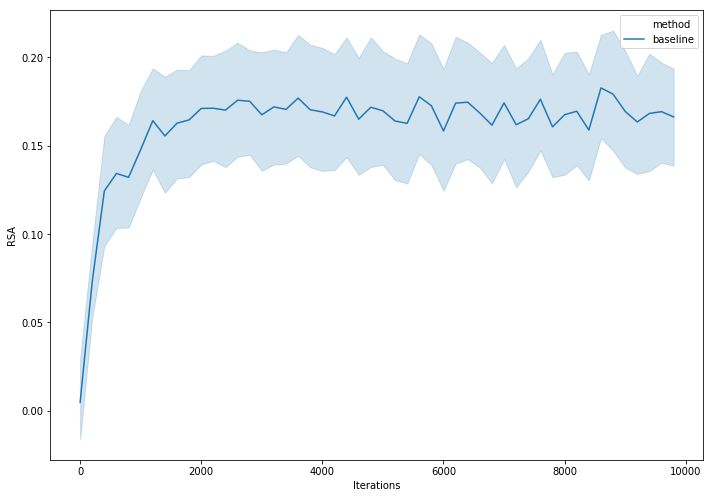

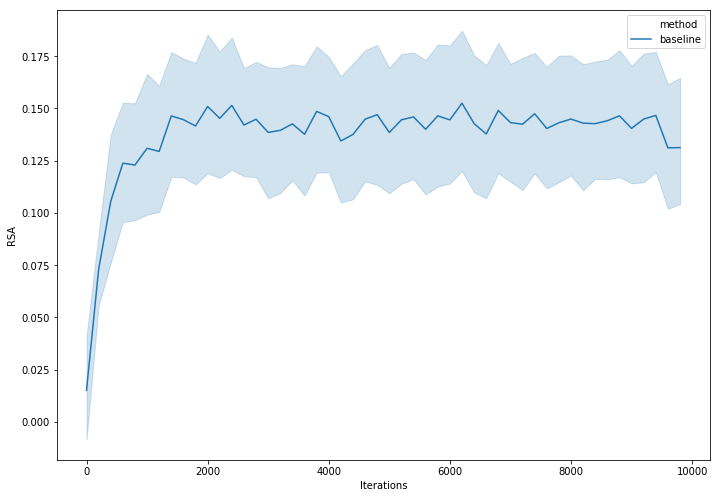

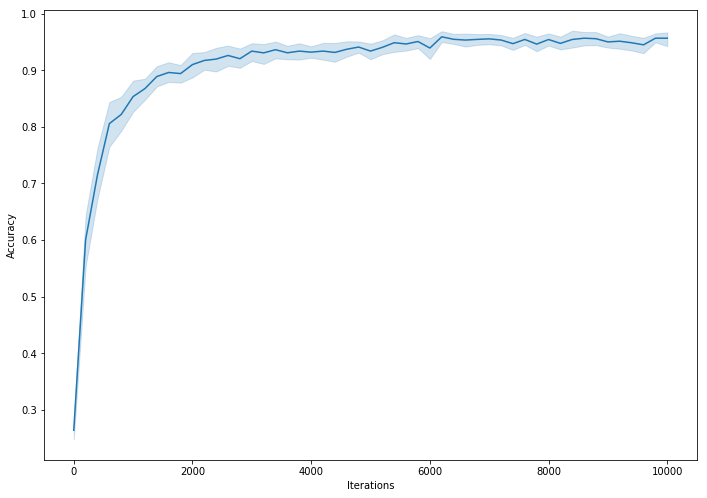

In [52]:
RSA_BASELINE = pickle.load(open(f'{baseline_path}/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {'baseline': RSA_BASELINE}

for k in RSA_BASELINE:
    if k == "ham_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k)#, title="Cross-seed RSA on Messages")
    elif k == "lev_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k, title="Messages (Levenshtein distance)")

paths = [
        'runs/lstm_max_len_5_vocab_5_attr_5',
        ]

plot_metric(paths, 'acc', title='Accuracy')

The results show that RSA values are quite low between languages (0.15~0.25). This indicates that the message spaces do not seem to be structurally similar to each other. Hence, we can conclude that agents converge to structurally different languages. If the agents where to converge to similar languages, the RSA values would be much higher. High RSA values would indicate that the languages are structurally similar to each other.


# Part 1: Hyperparameter search

As a first experiment, we will apply a hyperparameter search on the setup. The purpose of this experiment is to rule out the possibility that the initialization bias is caused by a certain hyperparameter or setup setting (the tricky part here is to decide when we have exhausted a hyperparameter or setup setting). The initialization bias means that agents converge to differently structured languages based on the values they are initialized on. Both hamming distance and Levenshtein distance will be used as distance measures between messages, to rule out the fact that the metric causes this bias to occur.

At first the effects of data shuffling will be measured. Secondly, the amount of attributes the agents have to describe will be altered. Thirdly, we will vary the environmental pressure by changing the vocabulary size and max length of the messages that can be created by the agents. 

## 1.1: Data shuffling
For this part, we initialize the dataloader with the same seed across all different initializations. The reason for doing so is to remove the possible effect created by the manner in which data is served into the model.

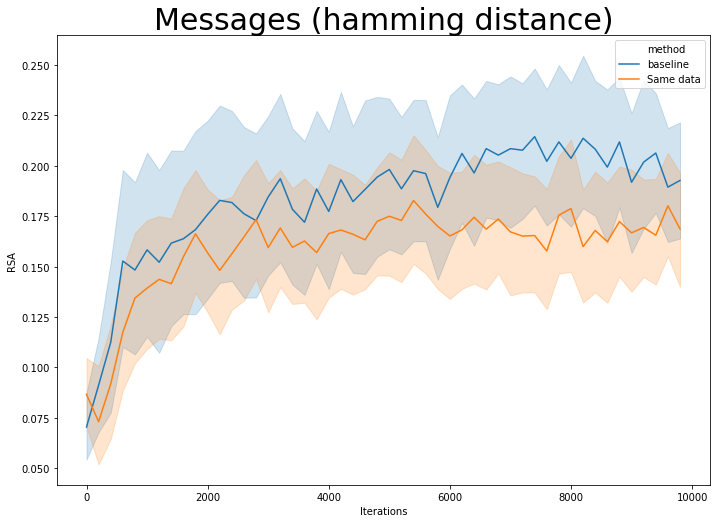

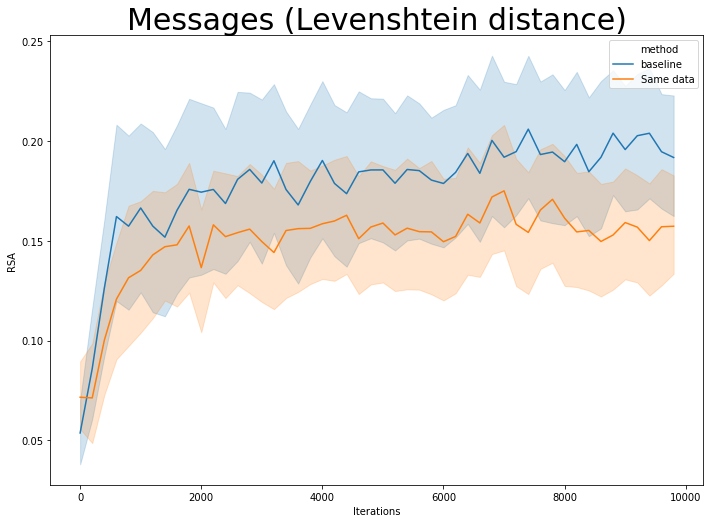

In [5]:
RSA_BASELINE = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_5/rsa_analysis.pkl', 'rb'))
RSA_SAME_DATA = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_same_data_attr_5/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {'baseline': RSA_BASELINE,
                'Same data': RSA_SAME_DATA}

for k in RSA_BASELINE:
    if k == "ham_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k, title="Messages (hamming distance)")
    elif k == "lev_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k, title="Messages (Levenshtein distance)")

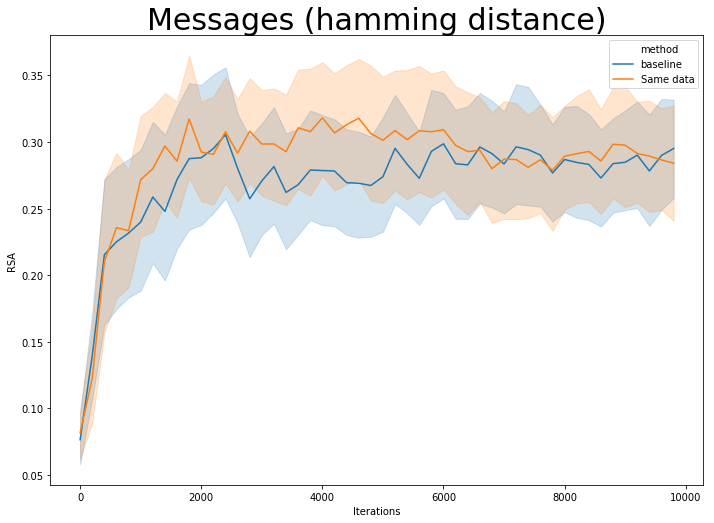

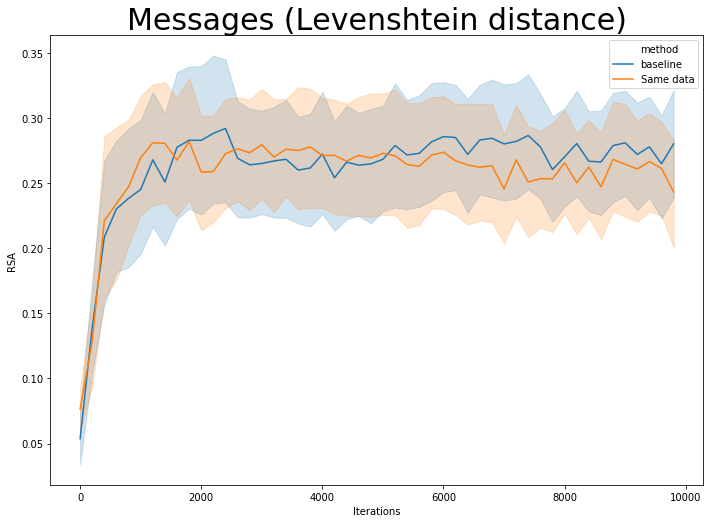

In [6]:
RSA_BASELINE = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_4/rsa_analysis.pkl', 'rb'))
RSA_SAME_DATA = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_same_data_attr_4/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {'baseline': RSA_BASELINE,
                'Same data': RSA_SAME_DATA}

for k in RSA_BASELINE:
    if k == "ham_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k, title="Messages (hamming distance)")
    elif k == "lev_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k, title="Messages (Levenshtein distance)")

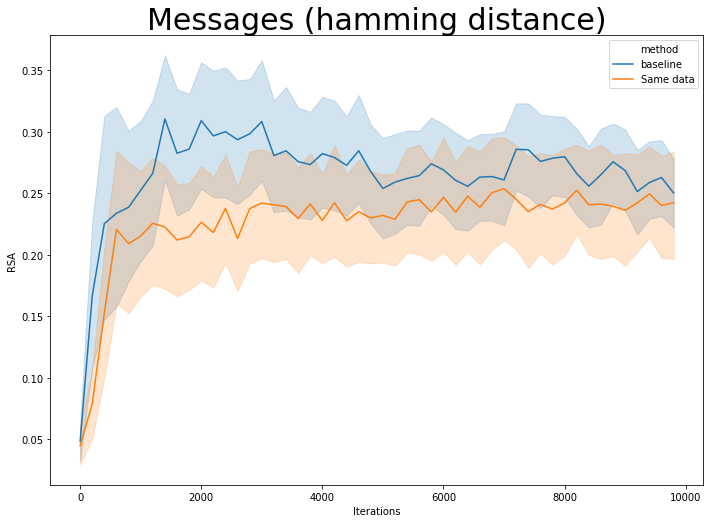

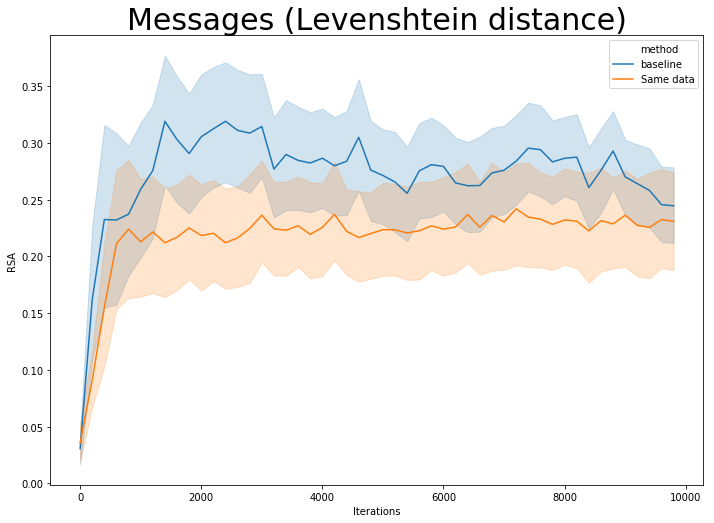

In [6]:
RSA_BASELINE = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_6/rsa_analysis.pkl', 'rb'))
RSA_SAME_DATA = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_same_data_attr_6/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {'baseline': RSA_BASELINE,
                'Same data': RSA_SAME_DATA}

for k in RSA_BASELINE:
    if k == "ham_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k, title="Messages (hamming distance)")
    elif k == "lev_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k, title="Messages (Levenshtein distance)")

In these plots, Ham Messages use the hamming distance metric and Lev Messages use the Levenshtein distance ratio to calculate the RSA.

It seems that the manner in which the data is shuffled does not alter the structure in the message that much. This might mean that the way of feeding data does not affect language emergence. 
Interesting finding, does it also occur on other environmental pressures or amount of attributes? What can we apply this on as well? 

## 1.2: Attributes

### Lower amounts of attributes

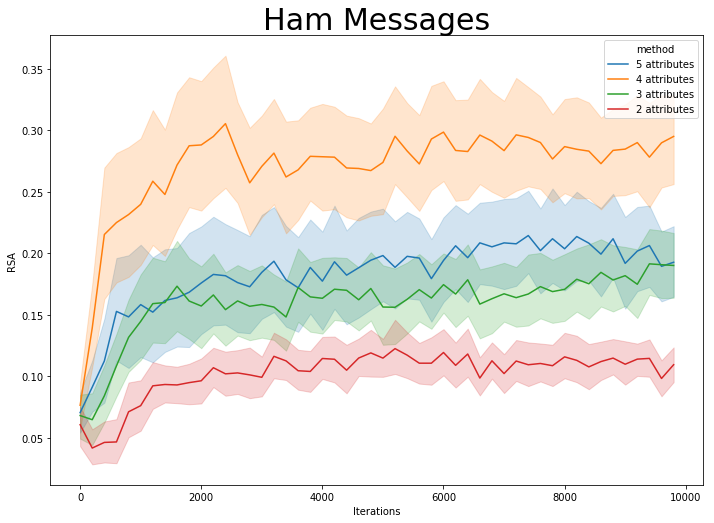

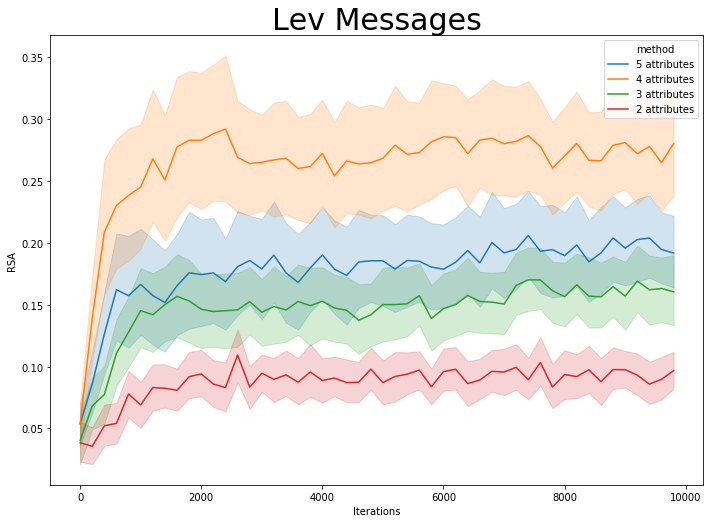

In [7]:
RSA_BASELINE = pickle.load(open(f'{baseline_path}/rsa_analysis.pkl', 'rb'))
RSA_4_ATTR = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_4/rsa_analysis.pkl', 'rb'))
RSA_3_ATTR = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_3/rsa_analysis.pkl', 'rb'))
RSA_2_ATTR = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_2/rsa_analysis.pkl', 'rb'))
 

RSA_ANALYSIS = {'5 attributes': RSA_BASELINE,
                '4 attributes': RSA_4_ATTR,
                '3 attributes': RSA_3_ATTR,
                '2 attributes': RSA_2_ATTR,
               }

for k in RSA_BASELINE:
    if k == "ham_messages" or k == "lev_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k)

Besides the effect of the amount of attributes, this figure also shows the effect of dataset size. This is due to the fact that more attributes cause the dataset to grow exponentially (since we create a dataset of every possible combination). --> maybe sample 

### Higher amounts of attributes

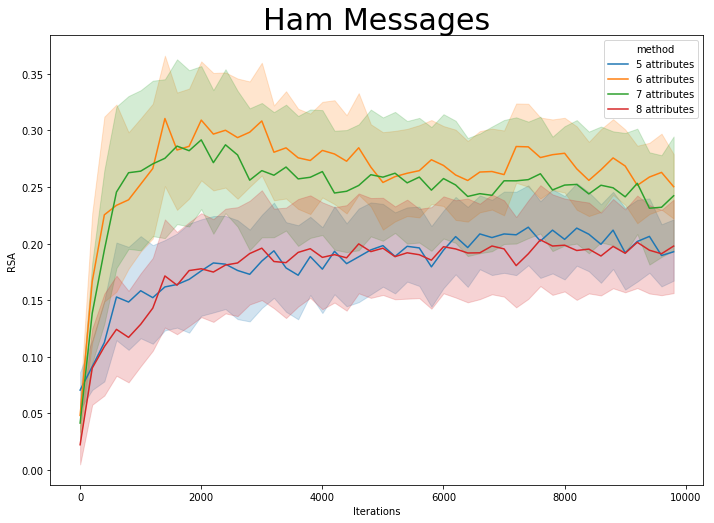

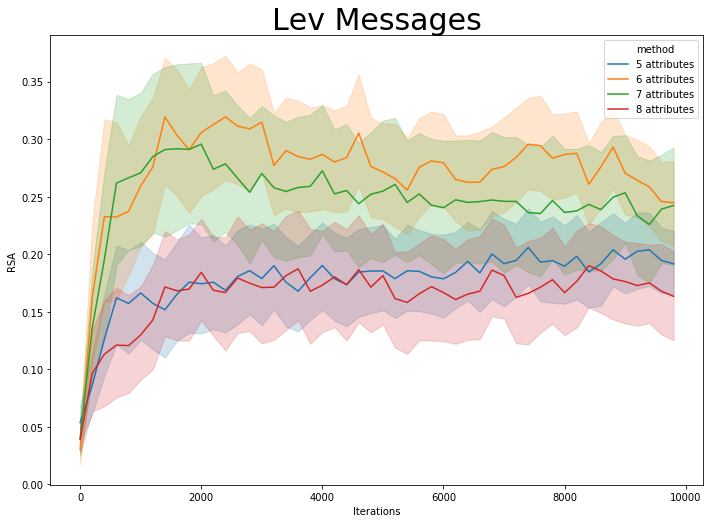

In [8]:
RSA_BASELINE = pickle.load(open(f'{baseline_path}/rsa_analysis.pkl', 'rb'))
RSA_6_ATTR = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_6/rsa_analysis.pkl', 'rb'))
RSA_7_ATTR = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_7/rsa_analysis.pkl', 'rb'))
RSA_8_ATTR = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_8/rsa_analysis.pkl', 'rb'))
 

RSA_ANALYSIS = {'5 attributes': RSA_BASELINE,
                '6 attributes': RSA_6_ATTR,
                '7 attributes': RSA_7_ATTR,
                '8 attributes': RSA_8_ATTR,
               }

for k in RSA_BASELINE:
    if k == "ham_messages" or k == "lev_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k)

While agents seem to perform better on 6 or 7 different attributes, the differences do not seem to be that significant. These differences are likely caused due to the differing size in the dataset. Notice that RSA jumps up very quickly and then stabilizes for the rest of the iterations. This might indicate that the agents choose a description of an object at the early stages of the game and then just stick with it.

## 1.3: Environmental pressure

Environmental pressure can be modified by restricting the agents to use a large vocabulary and a long message length. 

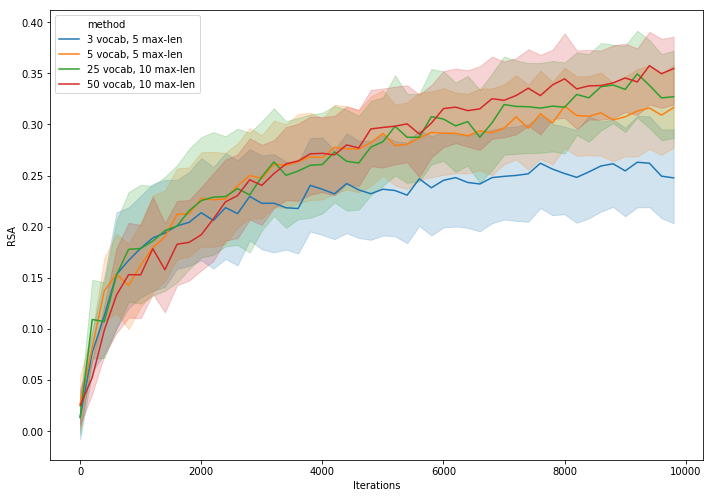

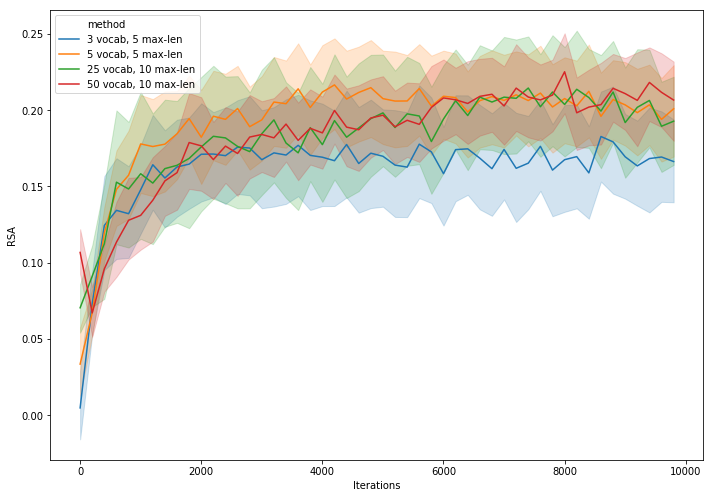

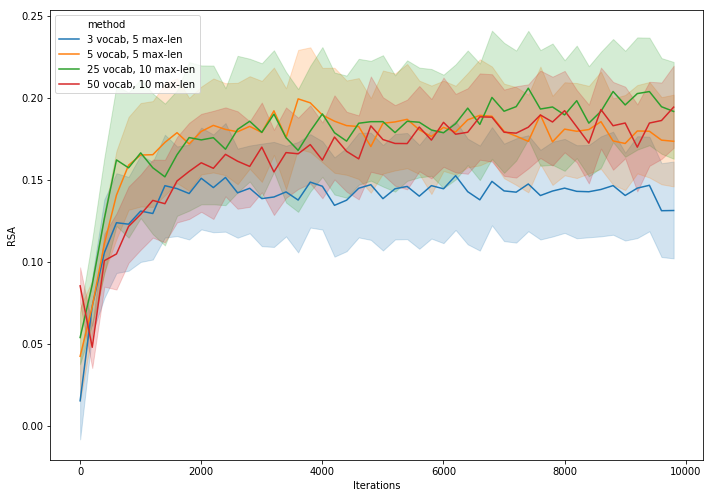

In [48]:
RSA_0 = pickle.load(open(f'runs/lstm_max_len_5_vocab_3_attr_5/rsa_analysis.pkl', 'rb'))
RSA_1 = pickle.load(open(f'runs/lstm_max_len_5_vocab_5_attr_5/rsa_analysis.pkl', 'rb'))
RSA_2 = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_5/rsa_analysis.pkl', 'rb'))
RSA_3 = pickle.load(open(f'runs/lstm_max_len_10_vocab_50_attr_5/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {
                '3 vocab, 5 max-len': RSA_0,
                '5 vocab, 5 max-len': RSA_1,
                '25 vocab, 10 max-len': RSA_2,
                '50 vocab, 10 max-len': RSA_3
               }

for k in RSA_0:
    if k == "ham_messages" or k == "lev_messages" or k =="h_receiver":
        plot_rsa_metric(RSA_ANALYSIS, metric=k, title="")

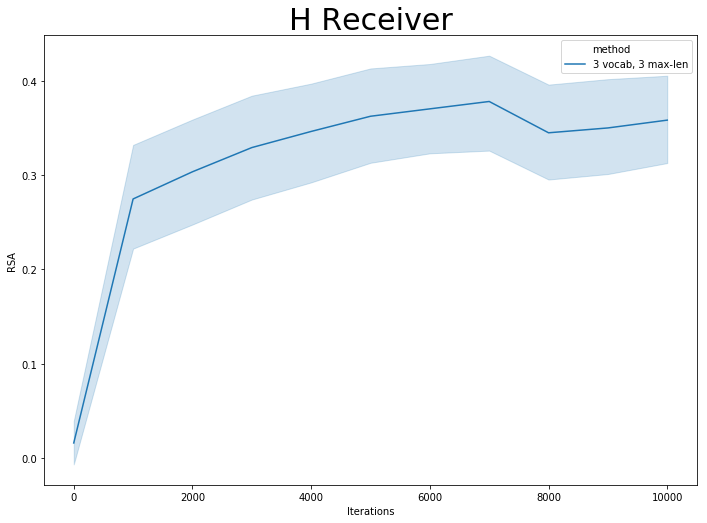

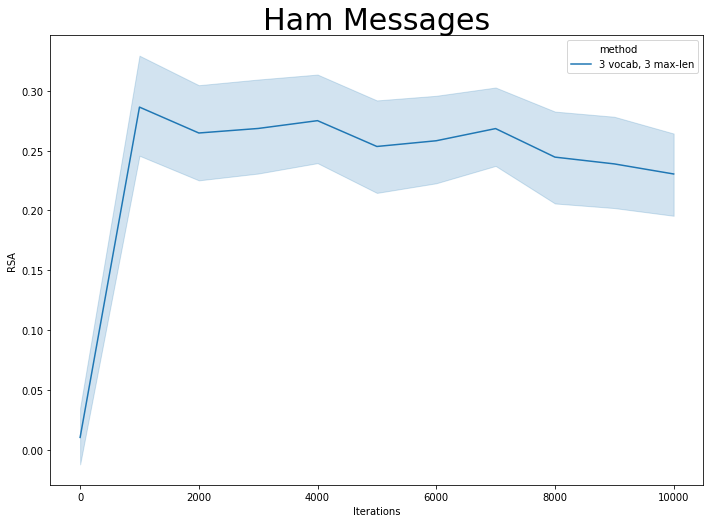

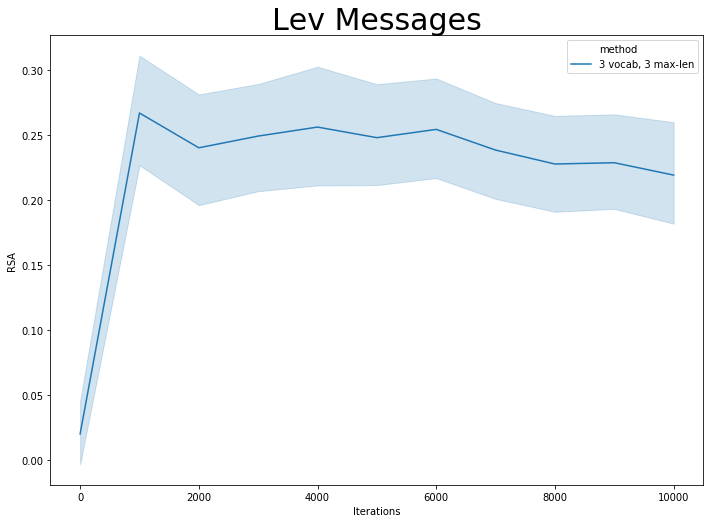

In [84]:
RSA_0 = pickle.load(open(f'runs/lstm_max_len_3_vocab_3_attr_5_split_2/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {
                '3 vocab, 3 max-len': RSA_0,
               }

for k in RSA_0:
    if k == "ham_messages" or k == "lev_messages" or k =="h_receiver":
        plot_rsa_metric(RSA_ANALYSIS, metric=k)

The results show that environmental pressures in the form of vocabulary sizes and max lengths do not seem to affect the message structure a lot. Only on the very small vocabulary size the results seem to differ slightly. This might indicate that vocabulary size and max length do not affect structure within emerging languages.

## 1.4 Similar distractors
In order to force agents to capture fundamental properties, we sample distractors based on the properties of the target. In this setup, differences between targets and distractors is capped to a single attribute. For example, the distractor can differ in color (e.g. red to green) as long as all other attributes (shape, location, etc.) are equal to that of the target. Having a higher level of similarity between targets and distractors might force agents to capture the fundamental properties of objects (e.g. colors), instead of having a much easier task that allows agents to loosely describe the objects to get a high performance. Which is likely the case for random sampling of distractors, since distractors will likely differ a lot from targets.

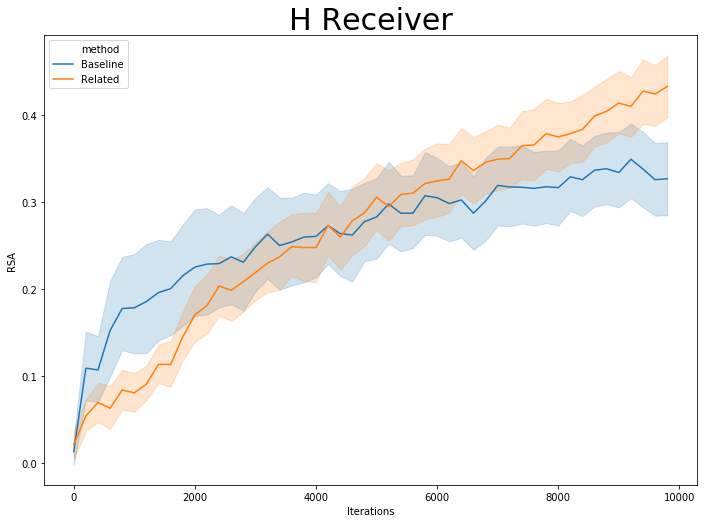

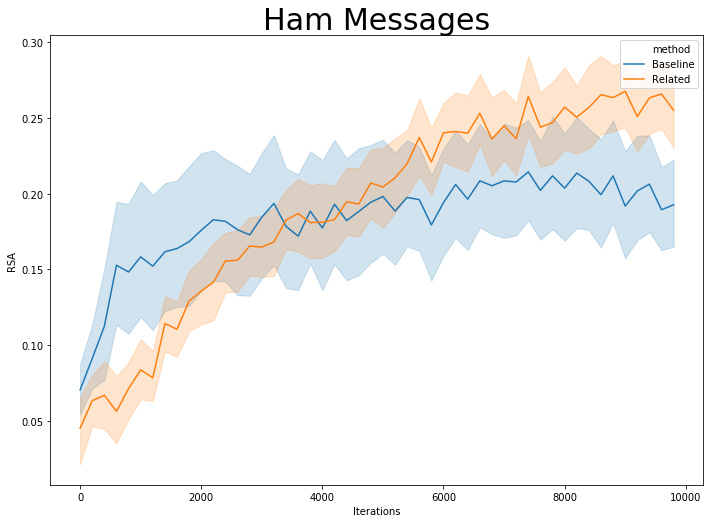

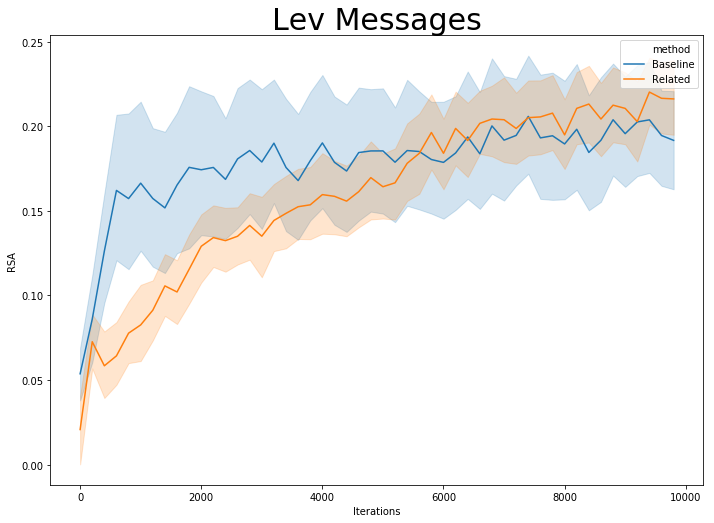

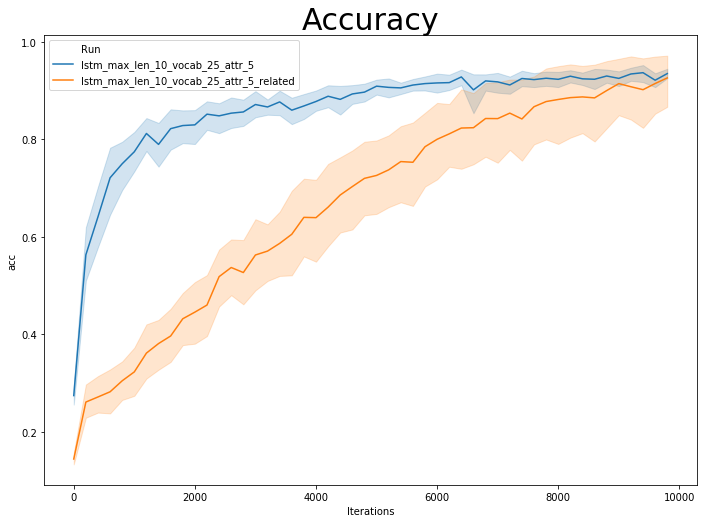

In [9]:
RSA_BASELINE = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_5/rsa_analysis.pkl', 'rb'))

RSA_RELATED = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_5_related/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {
                'Baseline' : RSA_BASELINE,
                'Related': RSA_RELATED,
               }

for k in RSA_BASELINE:
    if k == "ham_messages" or k == "lev_messages" or k == "h_receiver":
        plot_rsa_metric(RSA_ANALYSIS, metric=k)
        
paths = [
        'runs/lstm_max_len_10_vocab_25_attr_5',
        'runs/lstm_max_len_10_vocab_25_attr_5_related',
        ]

plot_metric(paths, 'acc', title='Accuracy')

On a larger size of vocabulary and max length, the plots start showing more gradual convergence of languages. At first the languages do not seem to show any strcuture, but later on they seem to surpass the baseline.
Maybe run this for more iterations? --> get the accuracy values

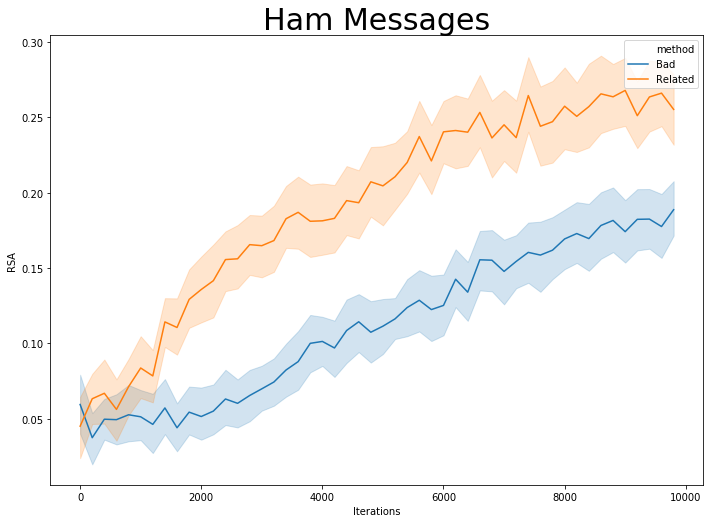

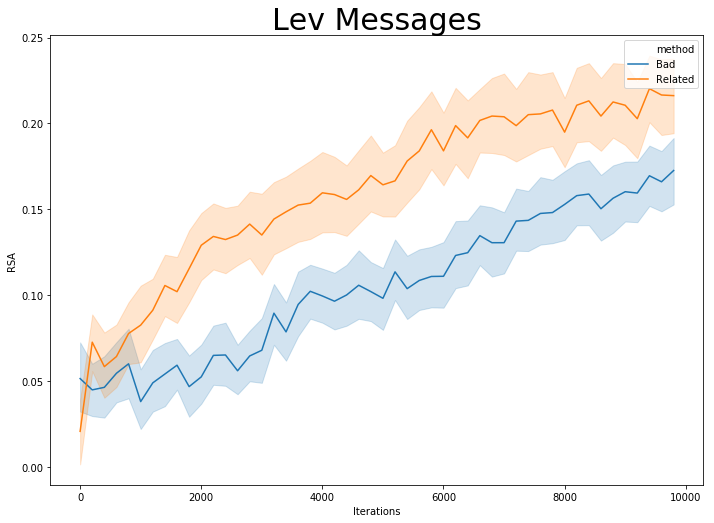

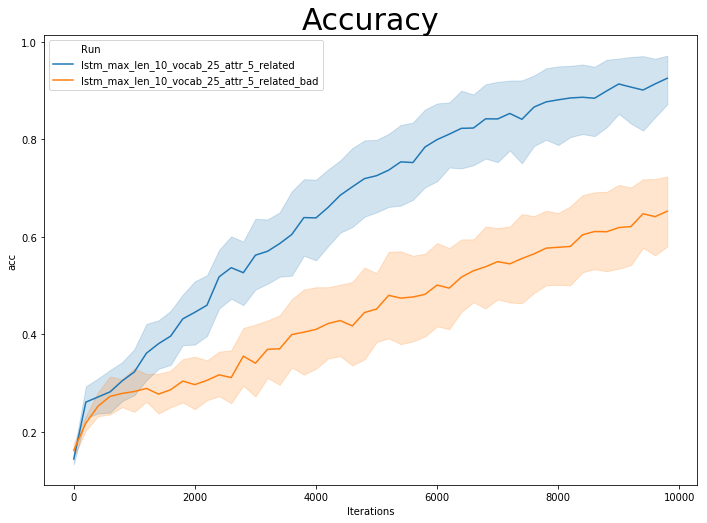

In [10]:
RSA_RELATED = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_5_related/rsa_analysis.pkl', 'rb'))
RSA_BAD = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_5_related_bad/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {
                'Bad' : RSA_BAD,
                'Related': RSA_RELATED,
               }

for k in RSA_BASELINE:
    if k == "ham_messages" or k == "lev_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k)
        
paths = [
        'runs/lstm_max_len_10_vocab_25_attr_5_related',
        'runs/lstm_max_len_10_vocab_25_attr_5_related_bad',
        ]

plot_metric(paths, 'acc', title='Accuracy')

If there are more attributes to describe, the agents might be forced to add structure to the language. Therefore, we up the amount of attributes to 6. KEEP IN MIND that agents are unable to reach acceptable levels of accuracy for the game, unless we set the embedding and hidden dimensions to 128 instead of 64.

BAD MEANS HIDDEN DIM IS NOT HIGH ENOUGH, SO GAME CAN NOT BE COMPLETED

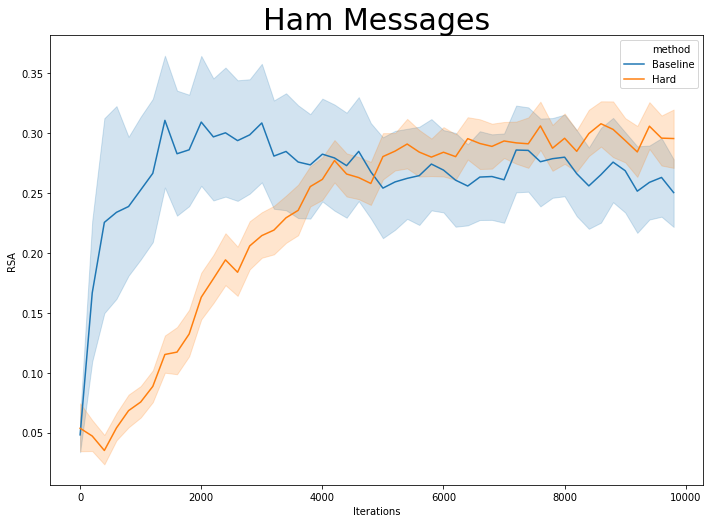

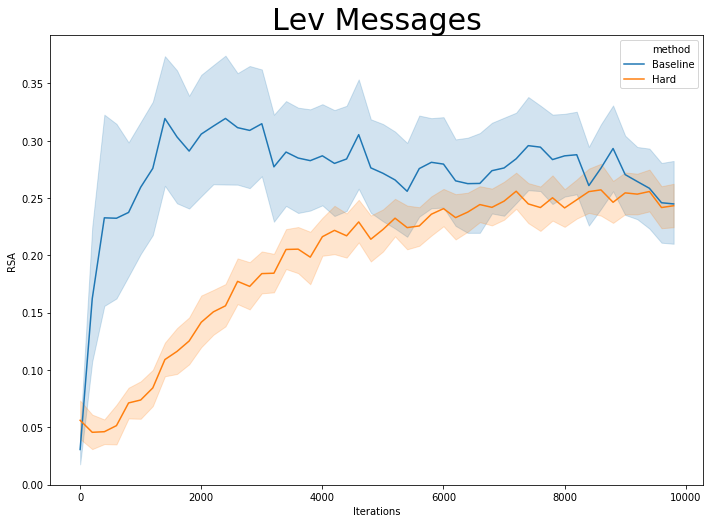

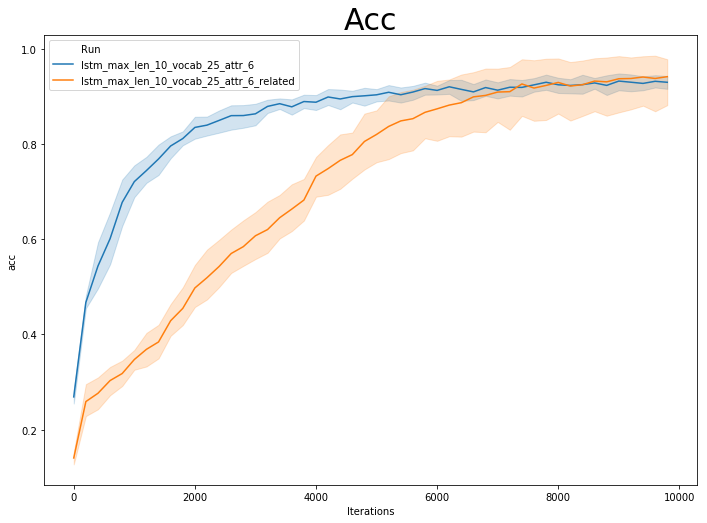

In [13]:
RSA_BASELINE = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_6/rsa_analysis.pkl', 'rb'))

RSA_HARD = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_6_related/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {
                'Baseline' : RSA_BASELINE,
                'Hard': RSA_HARD,
               }

for k in RSA_BASELINE:
    if k == "ham_messages" or k == "lev_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k)
        
        
paths = [
        'runs/lstm_max_len_10_vocab_25_attr_6',
        'runs/lstm_max_len_10_vocab_25_attr_6_related'
]

plot_metric(paths, 'acc')

At 6 attributes, agents perform significantly worse than baseline on the hard task. This might be due to the fact that they failed to converge to a good accuracy. Try making them converge and finding whether RSA increases.

# 1.5 Hidden size
In order to check for RSA to be a good metric, we try to limit the amount of solutions that agents can come up with using a lower hidden size. This might lead to higher RSA values.

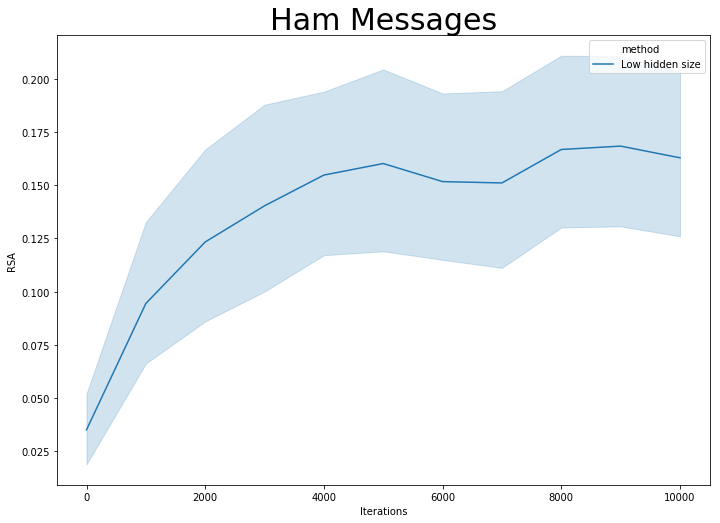

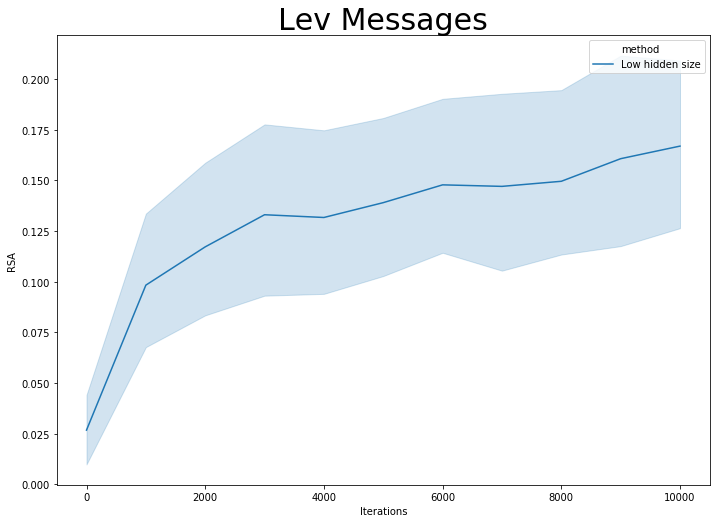

In [42]:
RSA_BASELINE = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_same_data_attr_5/rsa_analysis.pkl', 'rb'))

RSA_HIDDEN = pickle.load(open(f'runs/lstm_h_12_max_len_5_vocab_5_same_data_attr_5/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {
                'Low hidden size': RSA_HIDDEN,
               }

for k in RSA_BASELINE:
    if k == "ham_messages" or k == "lev_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k)     
    

# ------ Qualitative analysis ------

## Message composition
While looking at the plots I noticed that for most cases, RSA seems to increase drastically during the first couple of iterations. After this, it quickly stabilizes. This caused me to think that the referential game might be flawed for compositionality, due to the fact that agents decide together what objects will be named in language. Hence, they might want to agree as soon as possible to get the highest decrease in loss values. Actual final word meaning will be very close to initial word meaning, which might cause the initialization bias. In order to find out whether this phenomenon takes place, I show the messages from one of the setups.


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import glob
from collections import defaultdict

from analysis import *

vocab = pickle.load(open('data/dict_5.pckl', "rb"))

# load interesting metrics
path = "runs/lstm_max_len_5_vocab_5_attr_5"

metric_files = glob.glob(f"{path}/*/*.pkl")
seed_folders = glob.glob(f"{path}/*")

# generate 10 samples to be checked
indices = np.random.choice(243, 2, replace=False)

# add metric file, set checkpoints
metrics = [0, 200, 400, 600, 800, 1000, 2800, 5000, 7200, 9800]


result = {}
# run through all seed
for s in seed_folders:

    # get seed index
    seed = s.split("/")[-1]

    if seed == 'rsa_analysis.pkl':
        continue

    result[seed] = defaultdict(list)

    # run through selected metric iterations
    for metric in metrics:

        # combine file path
        file_path = s + "/metrics_at_{}.pkl".format(metric)

        # load files
        m1 = pickle.load(open(file_path, "rb"))

        # extract selected messages
        messages = m1['messages'][indices]
        targets = m1['targets'][indices]

        # use targets as key to save messagess
        for i in range(len(messages)):
            result[seed][str(targets[i])].append(messages[i])

# retrieve messages for specific targets

# pretty print the results
for tar, mess in result['1'].items():
    print('Messages for target:')
    print(tar)
    print()
    for i in range(len(mess)):
        if i == 0:
            print('iteration | ', end='')
            for j, seed in enumerate(result.keys()):
                if j < 6:
                    print("{:<13}".format('    seed ' + seed + ''), end="")
                    print(' | ', end='')
            print()

        print("{:<9}".format(str(metrics[i])), end='')
        print(' | ', end="")
            
        for j, seed in enumerate(result.keys()):
            if j < 6:
                print(result[seed][tar][i], end='')
                print(' | ', end='')
        print()
    print()
    
    for i in range(len(mess)):
        if i == 0:
            print('iteration | ', end='')
            for j, seed in enumerate(result.keys()):
                if j > 6:
                    print("{:<13}".format('    seed ' + seed + ''), end="")
                    print(' | ', end='')
            print()

        print("{:<9}".format(str(metrics[i])), end='')
        print(' | ', end="")
            
        for j, seed in enumerate(result.keys()):
            if j > 6:
                print(result[seed][tar][i], end='')
                print(' | ', end='')
        print()
    print()


Messages for target:
[0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]

iteration |     seed 3    |     seed 8    |     seed 7    |     seed 2    |     seed 4    |     seed 9    | 
0         | [6 1 1 1 1 1] | [6 5 7 7 7 7] | [6 4 4 4 4 4] | [6 2 2 0 2 3] | [6 1 1 1 1 1] | [6 2 2 4 4 4] | 
200       | [6 4 4 4 4 4] | [6 2 2 2 2 2] | [6 5 7 7 7 7] | [6 3 3 3 3 3] | [6 1 1 1 1 1] | [6 3 3 3 3 3] | 
400       | [6 4 4 4 4 4] | [6 2 2 2 3 3] | [6 4 4 4 4 4] | [6 3 4 4 4 4] | [6 1 1 1 1 1] | [6 0 0 0 0 0] | 
600       | [6 4 4 4 4 4] | [6 2 2 2 3 3] | [6 4 4 4 4 4] | [6 4 4 4 4 4] | [6 3 3 3 3 5] | [6 0 0 0 0 0] | 
800       | [6 4 4 4 4 4] | [6 2 2 3 3 3] | [6 4 4 4 4 4] | [6 4 4 3 4 4] | [6 3 3 3 5 7] | [6 0 0 0 0 0] | 
1000      | [6 4 4 4 4 4] | [6 2 2 2 3 3] | [6 4 4 4 4 4] | [6 4 0 4 4 0] | [6 3 3 3 5 7] | [6 0 0 0 0 0] | 
2800      | [6 4 4 4 4 4] | [6 2 2 2 3 3] | [6 4 4 4 4 4] | [6 4 0 4 4 4] | [6 3 3 3 5 7] | [6 2 0 0 0 0] | 
5000      | [6 4 4 4 4 4] | [6 2 2 2 3 3] | [6 4 4 4 4 4] |

The results show that, in some cases, the agents decide to represent an object according to a certain sequence very early on, afterwhich they never change it. For the seeds in which agents do tend to change their representation, changes rarely seem to be drastic. Agents tend to use similar characters while changing the representation. While this finding needs more proof, it might be a possible explanation of the initialization having such a large effect on emerging languages. Agents tend to create a representation very early on (thus largely basing it on initialization values), and barely change it afterwards.

Another finding is that some seeds cause agents to never change the representation of an object, while others do appear to make some changes. This is also a form of behaviour that is affected by the initialization.

# Hashing hypothesis
A possible explanation for this phenomenon could be the hashing hypothesis. This hypothesis states that a pair of agents agree on the description of an object very early on, and rarely change it. This would mean that they would just encode this object.

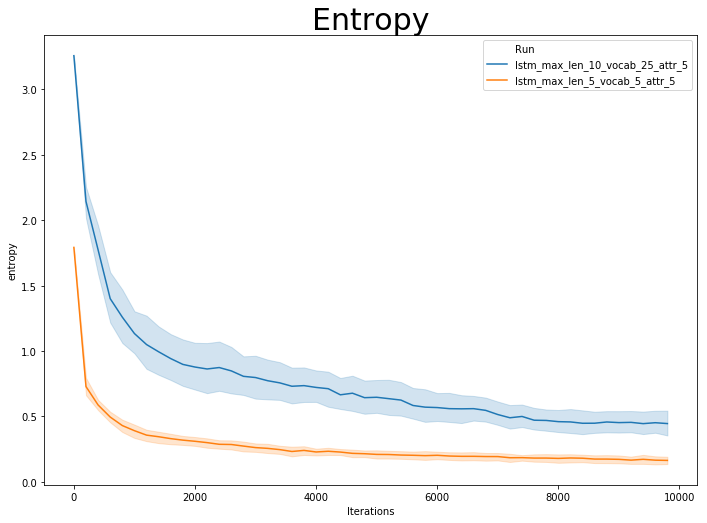

In [41]:
paths = [
        'runs/lstm_max_len_10_vocab_25_attr_5',
        'runs/lstm_max_len_5_vocab_5_attr_5'
        #'runs/lstm_max_len_10_vocab_25_attr_5_related',
        ]

plot_metric(paths, 'entropy', title='Entropy')

## Number of unique messages

In order to show more insight into the results, the number of unique messages is counted over the dataset. The dataset consists of a variable number of samples, based on the amount of attributes that describe these samples. 

In [35]:
from analysis import *
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# plot the unique messages
def plot_um(um_list, paths, level='messages'):

    # data to plot
    metrics = um_list[0]['1'].keys()
    n_groups = len(metrics)


    # create plot
    fig, ax = plt.subplots(figsize=(15,8))
    index = np.arange(n_groups)
    bar_width = 0.2
    opacity = 0.7
    
    # take average number of words
    for i, um in enumerate(um_list):
        
        # extract seeds and take average          
        sums = Counter()
        counters = Counter()
        
        std = defaultdict(list)
        
        # sum all values
        for itemset in um.values():
            sums.update(itemset)
            counters.update(itemset.keys())

            for key, value in itemset.items():
                std[key].append(value)
        
        # take average of summed values
        ret = {x: float(sums[x])/counters[x] for x in sums.keys()}

        # get standard deviation for every iteration
        for it in std.keys():
            std[it] = np.std(std[it])
      
        # turn path into label
        path = paths[i].replace('runs/lstm_', '')
        path = path.replace('_', '-')
        
        # plot the bar
        plt.bar(index + (i-1) * bar_width, ret.values(), bar_width,
                yerr=std.values(),
                alpha=opacity,
                label=path,
                error_kw=dict(lw=1, capsize=2, capthick=1))

    plt.xlabel('Iteration')
    if level == "messages":
        plt.ylabel('Number of unique messages')
        plt.title('Unique messages')
    else:
        plt.ylabel('Number of unique tokens')
        plt.title('Unique tokens')

    plt.xticks(index + ((len(paths)/3)-1) * bar_width, tuple([i for i in metrics]))
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return


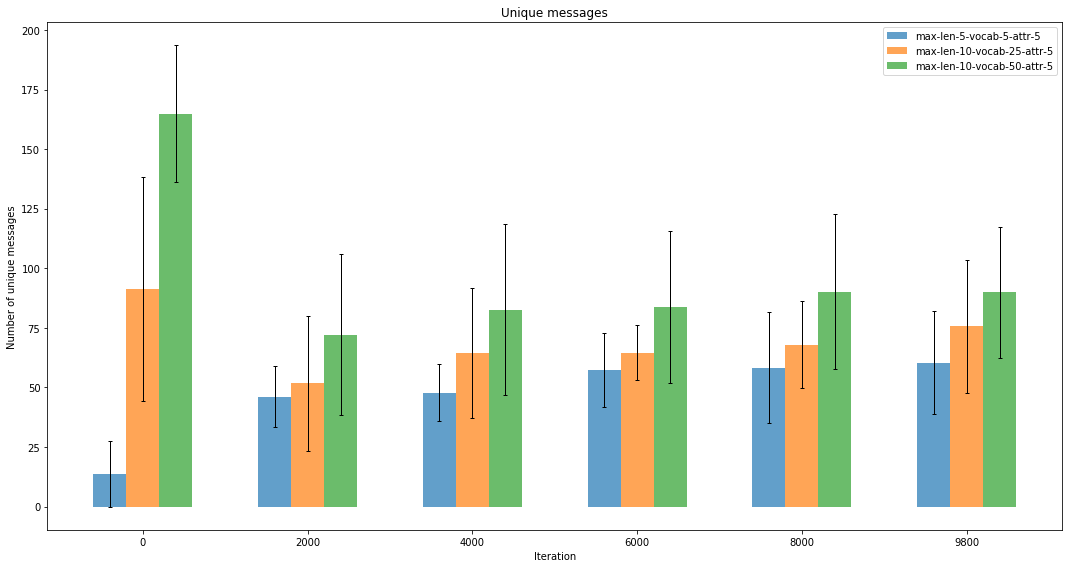

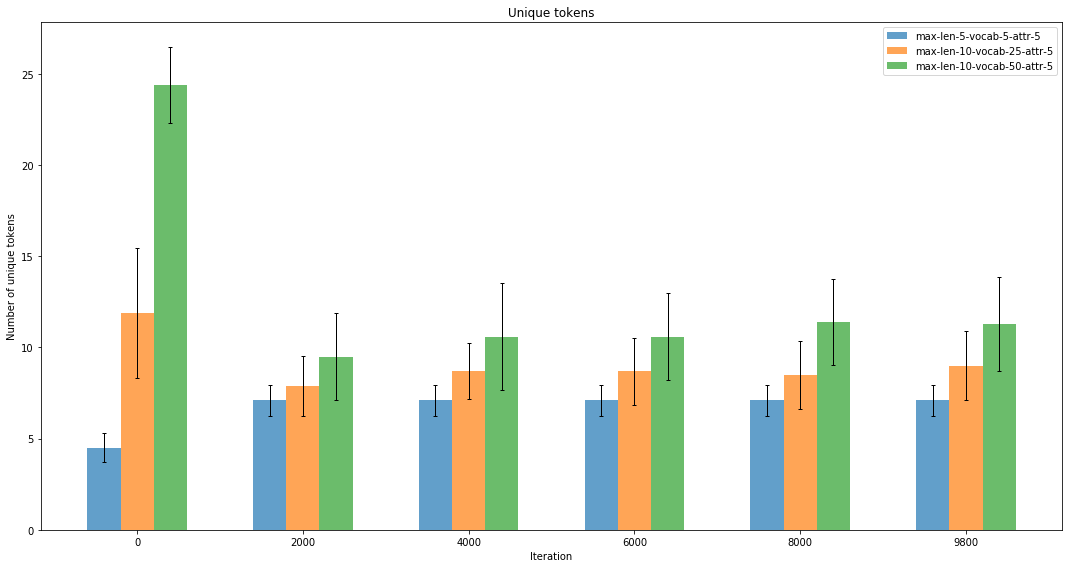

In [30]:
# load interesting metrics
paths = [         
         "runs/lstm_max_len_5_vocab_5_attr_5",
         "runs/lstm_max_len_10_vocab_25_attr_5",
         "runs/lstm_max_len_10_vocab_50_attr_5",
         #"runs/lstm_max_len_5_vocab_5_attr_5_related"
        ]

# add metric file, set checkpoints
#metrics = [0, 200, 400, 600, 800, 1000, 2800, 5000, 7200, 9800]
iterations = [0, 2000, 4000, 6000, 8000, 9800]

um_list = []
ut_list = []

for path in paths:
    # messages
    um = unique_messages(path, iterations, show_results=False)
    um_list.append(um)
    
    # tokens
    ut = unique_tokens(path, iterations, show_results=False)
    ut_list.append(ut)

plot_um(um_list, paths, 'messages')
plot_um(ut_list, paths, 'tokens')

# for seed, token in tokens.items():
#     print(token)



As can be seen in the plot, the agents do not nearly use an amount of unique messages close to the amount of objects. In this experiment, the agents are shown 243 unique objects. Even when they have a vocabulary of 50 characters and can create messages with a length of 10, they only use about 80 messages on average. This is in line with the finding that vocabulary size and message length do not affect the emerged languages by much. 

ALSO NOTE, that the vocab often reaches 8, while the max is set to 5. This is due to the fact that sos, eos and padding tokens also count as vocabulary, while the agents do not have access to these (only eos).

# ---------------------------------------------------------------------------------------------------------

In order to try and force the agents to use more distinct message and hopefully force them to add structure to their language, we make the task harder. Distractors will be sampled only when they are very similar to the target value. This way, we force the agents to capture fundamental properties of the objects.

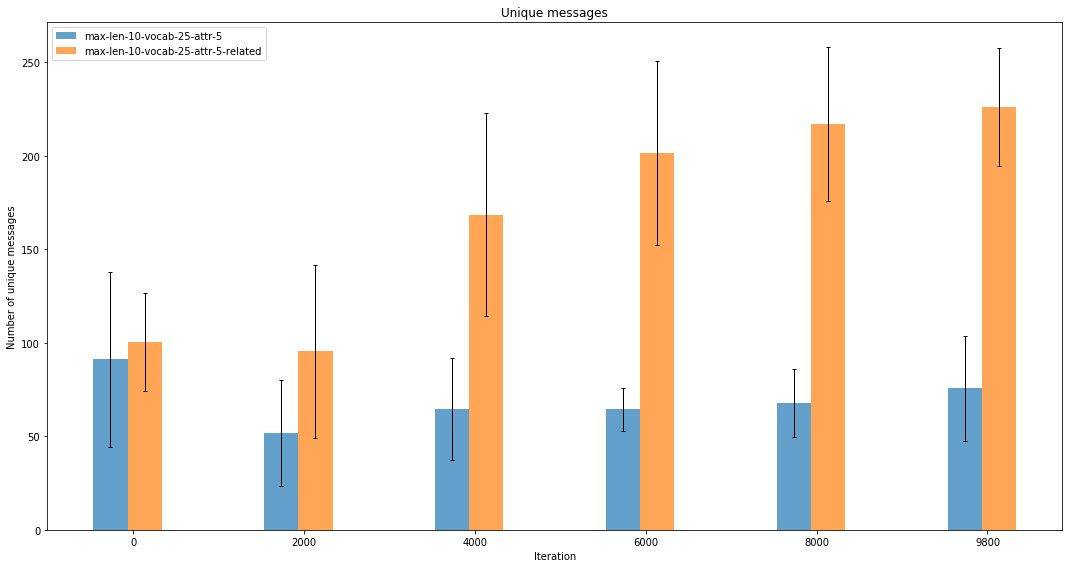

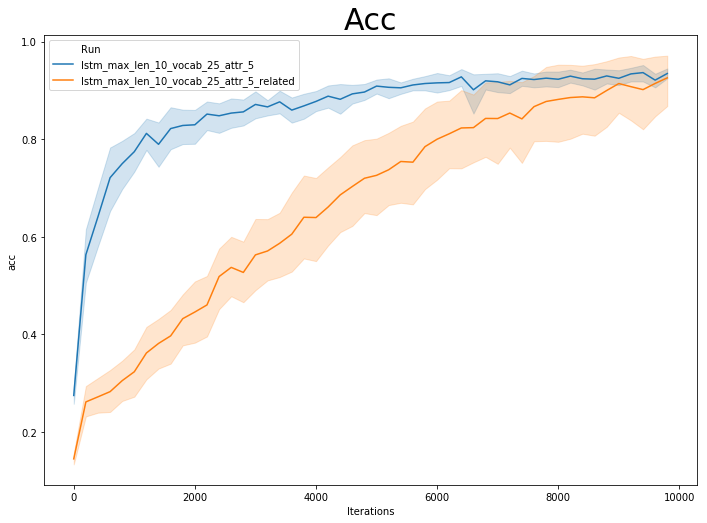

In [36]:
# load interesting metrics
paths = [         
         "runs/lstm_max_len_10_vocab_25_attr_5",
         "runs/lstm_max_len_10_vocab_25_attr_5_related",
        ]

# add metric file, set checkpoints
#metrics = [0, 200, 400, 600, 800, 1000, 2800, 5000, 7200, 9800]
metrics = [0, 2000, 4000, 6000, 8000, 9800]

um_list = []
for path in paths:
    um = unique_messages(path, metrics, show_results=False)
    um_list.append(um)

plot_um(um_list, paths)

paths = [
        'runs/lstm_max_len_10_vocab_25_attr_5',
        'runs/lstm_max_len_10_vocab_25_attr_5_related',
]

plot_metric(paths, 'acc')

The plot shows that agents now use more unique messages to describe the objects.

When having a large pool of vocabulary and max length, including the distractors that are comparable to the targets, we see that the amount of messages comes close to the amount of objects.

In [ ]:
# load interesting metrics
paths = [         
         "runs/lstm_max_len_10_vocab_25_attr_6",
         "runs/lstm_max_len_10_vocab_25_attr_6_related"
        ]

# add metric file, set checkpoints
metrics = [0, 200, 400, 600, 800, 1000, 2800, 5000, 7200, 9800]

um_list = []
for path in paths:
    um = unique_messages(path, metrics, show_results=False)
    um_list.append(um)

plot_um(um_list, paths)

## Target/message RSA

KeyError: 'RSA:targets/messages'

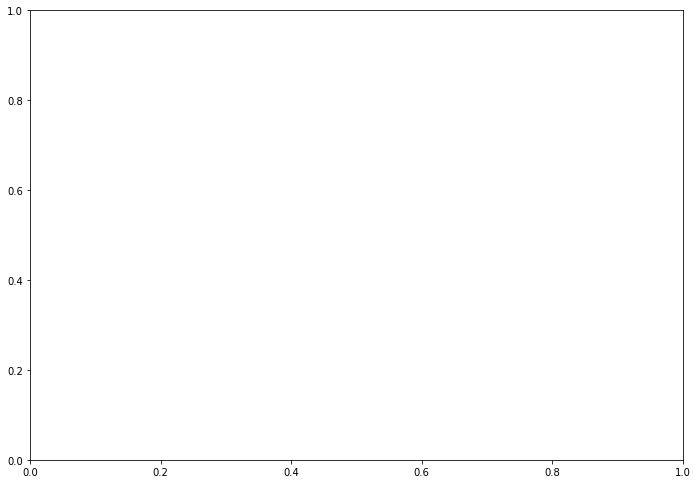

In [20]:
paths = [
        'runs/lstm_max_len_10_vocab_25_attr_5',
        'runs/lstm_max_len_10_vocab_25_attr_5_related'
]

plot_metric(paths, 'RSA:targets/messages')

The RSA is probably similar due to the nature of the metric. If similar messages are used for the same objects, RSA will be high.

KeyError: 'RSA:targets/messages'

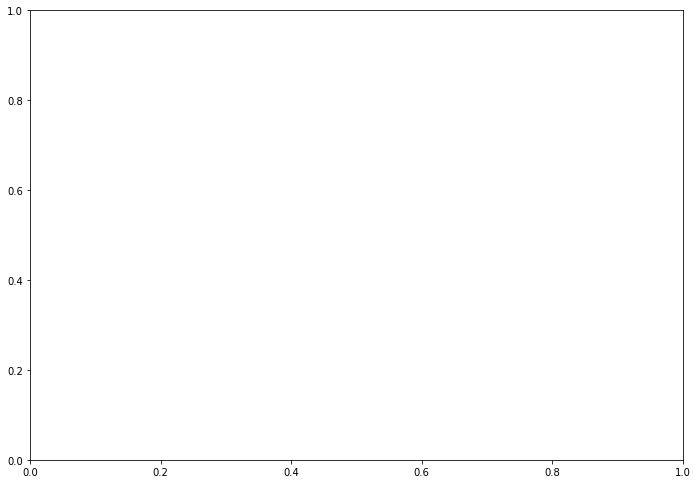

In [21]:
paths = [
        'runs/lstm_max_len_10_vocab_25_attr_5',
        'runs/lstm_max_len_10_vocab_25_attr_5_related'
]

plot_metric(paths, 'RSA:targets/messages')

# Find RSA outliers

In [80]:
import operator

def get_outliers(result, metric=None):
    # get data to fill up plot
    #generations = []
    values = {}
    #run_names = []

    for s in list(result[metric].keys()):  

        # check if list is not empty
        if not list(result[metric][s].keys()):
            continue

        for g in sorted(list(result[metric][s].keys())):
            values[(s, g)] = result[metric][s][g]

    # find the max value
    max_value = max(values.items(), key=operator.itemgetter(1))[0]
    print(max_value)
    print(values[max_value])
    
    print() 
    
    min_value = min(values.items(), key=operator.itemgetter(1))[0]
    print(min_value)
    print(values[min_value])
    
    # for every seed pair, sort dict to get the lowest value for each seed pair --> hashing hypothesis
    
    
    # sort the dictionary
    output = dict(sorted(values.items(), key=lambda x: x[1], reverse=True)[:20])
    print(output)


In [81]:
get_outliers(RSA_BASELINE, "ham_messages")

('45', 800)
0.7273687473510133

('21', 0)
-0.07748549958815401
{('45', 800): 0.7273687473510133, ('45', 1200): 0.6778981257267158, ('45', 1000): 0.6760109543038263, ('45', 600): 0.6746885382144815, ('45', 1400): 0.6457536429427729, ('45', 2200): 0.6413883363424023, ('45', 1800): 0.6391803795203566, ('37', 2600): 0.6382103947150692, ('45', 2000): 0.6305329300753779, ('37', 2000): 0.6240170843202992, ('45', 1600): 0.6210579848753672, ('37', 2200): 0.6144065791024644, ('45', 5000): 0.6091312452496496, ('37', 4800): 0.601483312929106, ('37', 7000): 0.5993432411257973, ('37', 4600): 0.5869937113177821, ('45', 3000): 0.577602308919228, ('45', 4600): 0.5772481394255958, ('37', 2400): 0.5739176105145034, ('37', 3400): 0.572000744407093}
